<a href="https://www.kaggle.com/code/gpreda/test-gemma-3n-4b-multimodal-with-unsloth?scriptVersionId=253964470" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction

This Notebook introduces few test with Gemma 3n 4B multimodal with Unsloth.
It is based on [Gemma 3N 4B Multimodal finetuning + inference](https://www.kaggle.com/code/danielhanchen/gemma-3n-4b-multimodal-finetuning-inference) notebook from Unsloth.

What you can find here:
* Tests with text-only questions
* Experiments with image input
* Tests with sound input
* Full multi-modal questions: sound, image, and text input and questions about the combined multi-modal input

Useful resources:
* [Gemma 3n: How to Run & Fine-tune](https://docs.unsloth.ai/basics/gemma-3n-how-to-run-and-fine-tune)
* [HuggingFace: unsloth/gemma-3n-E4B-it-GGUF](https://huggingface.co/unsloth/gemma-3n-E4B-it-GGUF)
* [Gemma 3n Fine-tuning now in Unsloth - 1.5x faster with 50% less VRAM + Fixes](https://www.reddit.com/r/LocalLLaMA/comments/1lp5nhy/gemma_3n_finetuning_now_in_unsloth_15x_faster/)
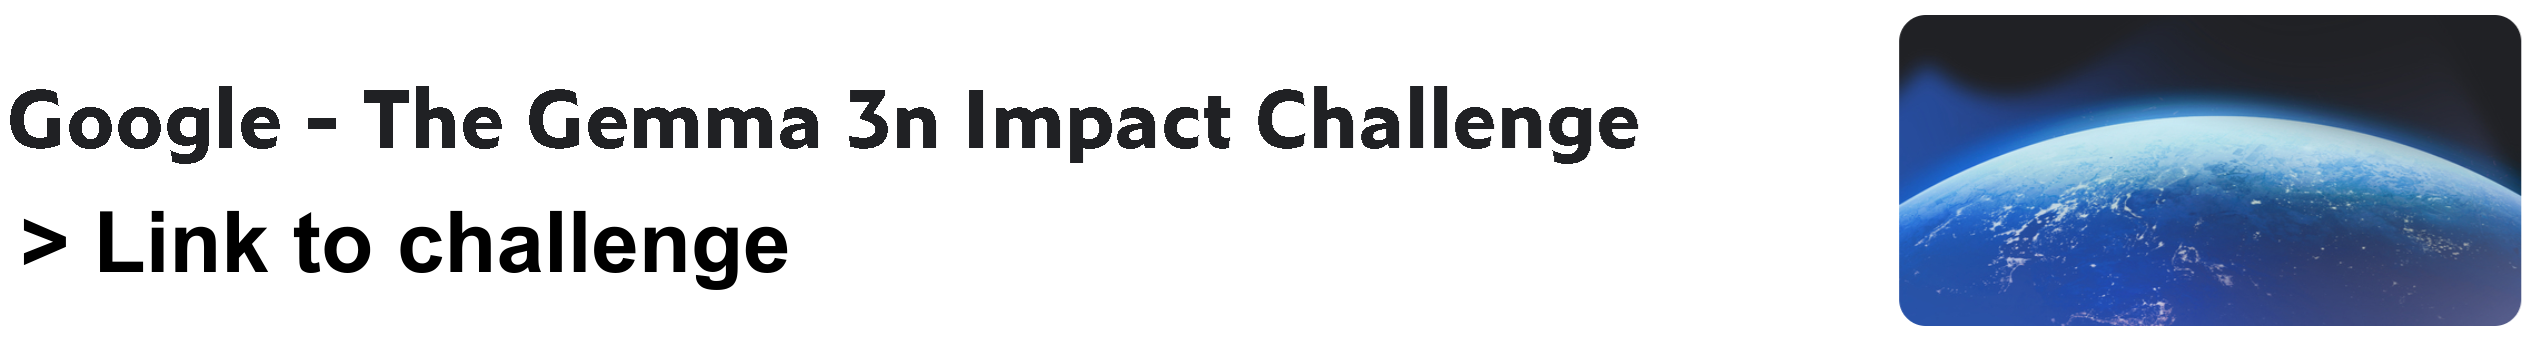
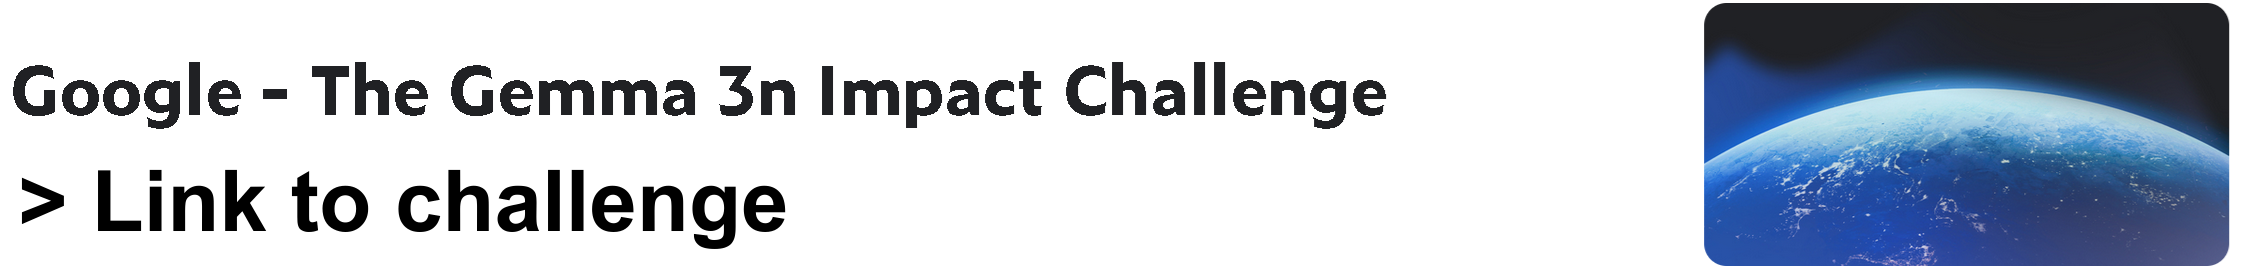

# Install packages

In [1]:
%%capture
# Install Unsloth
!pip install unsloth

In [2]:
%%capture
# Install latest transformers for Gemma 3N
!pip install --no-deps --upgrade transformers # Only for Gemma 3N
!pip install --no-deps --upgrade timm # Only for Gemma 3N

# Prepare model

We install needed packages and initialize model and tokenizer.
From the available `Gemma 3N` models we will use `unsloth/gemma-3n-E4B-it` (Gemma 3N 4B instruction tuned).

`FastModel` supports loading nearly any model now! This includes Vision, Text and Audio models!

In [3]:
import os
from unsloth import FastModel
import torch

fourbit_models = [
    # 4bit dynamic quants for superior accuracy and low memory use
    "unsloth/gemma-3n-E4B-it-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-it-unsloth-bnb-4bit",
    # Pretrained models
    "unsloth/gemma-3n-E4B-unsloth-bnb-4bit",
    "unsloth/gemma-3n-E2B-unsloth-bnb-4bit",

    # Other Gemma 3 quants
    "unsloth/gemma-3-1b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-4b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-12b-it-unsloth-bnb-4bit",
    "unsloth/gemma-3-27b-it-unsloth-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastModel.from_pretrained(
    model_name = "unsloth/gemma-3n-E4B-it", # Or "unsloth/gemma-3n-E2B-it"
    dtype = None, # None for auto detection
    max_seq_length = 1024, # Choose any for long context!
    load_in_4bit = True,  # 4 bit quantization to reduce memory
    full_finetuning = False, # [NEW!] We have full finetuning now!
    # token = "hf_...", # use one if using gated models
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


2025-08-03 11:32:03.173832: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754220723.382367      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754220723.443473      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.8.1: Fast Gemma3N patching. Transformers: 4.54.1.
   \\   /|    Tesla T4. Num GPUs = 2. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.7.1+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.3.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.31.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Unsloth: Gemma3N does not support SDPA - switching to eager!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/3.72G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.15G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/98.0 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/33.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/777 [00:00<?, ?B/s]

# Test Gemma 3N with multi-modal content

Gemma 3N can process Text, Vision and Audio!

Let's first experience how Gemma 3N can handle multimodal inputs. We use Gemma 3N's recommended settings of:
* `temperature = 1.0`
* `top_p = 0.95`  
* `top_k = 64`


We define a function for inference. It will first tokenize the messages and then use `generate` function to generate the output.


In [4]:
import torch
import gc

import torch._dynamo
torch._dynamo.config.suppress_errors = True
torch._dynamo.config.cache_size_limit = 512

def do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens=128):
    # Tokenize input with chat template
    inputs = tokenizer.apply_chat_template(
        messages,
        add_generation_prompt=True,
        tokenize=True,
        return_dict=True,
        return_tensors="pt"
    ).to("cuda")

    # Generate output (no streamer as in the initial Notebook)
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=1.0,
        top_p=0.95,
        top_k=64,
        do_sample=True
    )

    # Decode just the new generated tokens (excluding prompt)
    generated_text = tokenizer.decode(
        output_ids[0][inputs['input_ids'].shape[-1]:], 
        skip_special_tokens=True
    )

    # Cleanup to reduce VRAM usage
    del inputs
    torch.cuda.empty_cache()
    gc.collect()

    return generated_text


## Text-only input

Let's start with text-only input.

In [5]:
messages = [
        {
    "role": "system",
    "content": [{ "type" : "text",
                  "text" : "Answer briefly, be laconic if possible." }]
    },
    {
    "role": "user",
    "content": [{ "type" : "text",
                  "text" : "Who was George Washington?" }]
}]
output = do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens = 16)
print(output)

First President of the United States; key figure in the American Revolutionary War.



Let's create a function that enclose all this.

We start with a filtering and coloring function.

In [6]:
from IPython.display import display, Markdown

def colorize_text(text):
    for word, color in zip(["Question", "Answer","Execution time"], ["blue", "red", "green"]):
        text = text.replace(f"{word}:", f"\n\n**<font color='{color}'>{word}:</font>**")
    return text

In [7]:
import numpy as np
from time import time
def run_query(user_input, max_new_tokens=128, model=model, tokenizer=tokenizer):
    _start = time()
    messages = [
        {
    "role": "system",
    "content": [{ "type" : "text",
                  "text" : "Answer briefly, be laconic if possible." }]
    },
    {
    "role": "user",
    "content": [{ "type" : "text",
                  "text" : user_input }]
    }]
    output = do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens = max_new_tokens)
    _end = time()
    formated_output = f"Question: {user_input}\nAnswer: {output}\nExecution time: {np.round(_end-_start, 2)} sec."
    display(Markdown(colorize_text(formated_output)))
    
    

### Let's test with some history questions

In [8]:
run_query("Who was George Washington?", max_new_tokens=16)



**<font color='blue'>Question:</font>** Who was George Washington?


**<font color='red'>Answer:</font>** First President of the United States; key figure in the American Revolution.



**<font color='green'>Execution time:</font>** 4.99 sec.

In [9]:
run_query("When was the WWI?", max_new_tokens=16)



**<font color='blue'>Question:</font>** When was the WWI?


**<font color='red'>Answer:</font>** 1914-1918.



**<font color='green'>Execution time:</font>** 3.32 sec.

In [10]:
run_query("When was The War of 30 years?", 16)



**<font color='blue'>Question:</font>** When was The War of 30 years?


**<font color='red'>Answer:</font>** 1618-1648.



**<font color='green'>Execution time:</font>** 3.33 sec.

In [11]:
run_query("Who was JFK?", 32)



**<font color='blue'>Question:</font>** Who was JFK?


**<font color='red'>Answer:</font>** 35th President of the United States (1961-1963), assassinated.



**<font color='green'>Execution time:</font>** 5.73 sec.

In [12]:
run_query("Who was Xenophon?", 32)



**<font color='blue'>Question:</font>** Who was Xenophon?


**<font color='red'>Answer:</font>** Ancient Greek historian and soldier.



**<font color='green'>Execution time:</font>** 2.52 sec.

In [13]:
run_query("Who was Meiji?", 32)



**<font color='blue'>Question:</font>** Who was Meiji?


**<font color='red'>Answer:</font>** Emperor Meiji of Japan (reigned 1868-1912).



**<font color='green'>Execution time:</font>** 5.47 sec.

### Let's follow with some popular culture questions

In [14]:
run_query("Name 3 songs by Beach Boys.", 32)



**<font color='blue'>Question:</font>** Name 3 songs by Beach Boys.


**<font color='red'>Answer:</font>** 1.  "Good Vibrations"
2.  "Surfin' USA"
3.  "Wouldn't It Be Nice" 



**<font color='green'>Execution time:</font>** 7.63 sec.

In [15]:
run_query("Who was Maradona?", 32)



**<font color='blue'>Question:</font>** Who was Maradona?


**<font color='red'>Answer:</font>** Argentine football (soccer) legend, widely considered one of the greatest of all time.



**<font color='green'>Execution time:</font>** 5.03 sec.

In [16]:
run_query("When was released first time the show 'Dallas' in US?", 32)



**<font color='blue'>Question:</font>** When was released first time the show 'Dallas' in US?


**<font color='red'>Answer:</font>** April 19, 1978.



**<font color='green'>Execution time:</font>** 3.59 sec.

In [17]:
run_query("When was released the first Star Wars movie?", 32)



**<font color='blue'>Question:</font>** When was released the first Star Wars movie?


**<font color='red'>Answer:</font>** May 25, 1977.



**<font color='green'>Execution time:</font>** 3.49 sec.

In [18]:
run_query("Name 3 most famous albums of The Beatles.", 32)



**<font color='blue'>Question:</font>** Name 3 most famous albums of The Beatles.


**<font color='red'>Answer:</font>** 1. *Sgt. Pepper's Lonely Hearts Club Band*
2. *Abbey Road*
3. *The Beatles* (aka "


**<font color='green'>Execution time:</font>** 7.61 sec.

In [19]:
run_query("What is the real name of Madonna?", 32)



**<font color='blue'>Question:</font>** What is the real name of Madonna?


**<font color='red'>Answer:</font>** Madonna Louise Ciccone.



**<font color='green'>Execution time:</font>** 2.22 sec.

## Image input

Let's check now with images.

We start with the image of a historical figure.

![](https://media.cnn.com/api/v1/images/stellar/prod/231120172101-lead-image-john-f-kennedy-life-career.jpg)

For flexibility, we turn back to the initial function, so that we can compose the messages as we wish.


In [20]:
jfk_link = "https://media.cnn.com/api/v1/images/stellar/prod/231120172101-lead-image-john-f-kennedy-life-career.jpg"
user_input = "Describe this picture."

_start = time()
 
messages = [
    {"role": "system",
    "content": [{ "type" : "text",
                  "text" : "Answer briefly, be laconic if possible." }]
    },
    {"role" : "user",
    "content": [
        { "type": "image", "image" : jfk_link },
        { "type": "text",  "text" : user_input}
    ]
}]
       
output = do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens = 32)
_end = time()
formated_output = f"Question: {user_input}\nAnswer: {output}\nExecution time: {np.round(_end-_start, 2)} sec."
display(Markdown(colorize_text(formated_output)))
    



**<font color='blue'>Question:</font>** Describe this picture.


**<font color='red'>Answer:</font>** A portrait of John F. Kennedy in a suit and tie, seated in a chair.


**<font color='green'>Execution time:</font>** 48.23 sec.

## Sound input

Gemma 3N can also hear! Let's test with an audio sample.

This is a famous speech of JFK about the vision of putting a man on the Moon.

In [21]:
from IPython.display import Audio, display
Audio("https://www.nasa.gov/wp-content/uploads/2015/01/591240main_JFKmoonspeech.mp3")

Let's download the sound.

In [22]:
!wget -qqq https://www.nasa.gov/wp-content/uploads/2015/01/591240main_JFKmoonspeech.mp3 -O audio.mp3

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [23]:
audio_file = "audio.mp3"
user_input = "What is this audio about?"
_start = time()
messages = [{
    "role" : "user",
    "content": [
        { "type": "audio", "audio" : audio_file },
        { "type": "text",  "text" :  user_input}
    ]
}]
output = do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens = 32)
_end = time()
formated_output = f"Question: {user_input}\nAnswer: {output}\nExecution time: {np.round(_end-_start, 2)} sec."
display(Markdown(colorize_text(formated_output)))



**<font color='blue'>Question:</font>** What is this audio about?


**<font color='red'>Answer:</font>** The audio is a quote from President John F. Kennedy's 1961 presidential address to Congress. In this speech, he passionately calls for the


**<font color='green'>Execution time:</font>** 42.08 sec.

## Text-image-sound multimodal input

Let's combine now text, image, sound in a multimodal input.

We are also adding a new image.

In [24]:
moon_link = "https://ichef.bbci.co.uk/ace/standard/976/cpsprodpb/F574/production/_107563826_astronautedwine.aldrin-onthe-moon.jpg"

![](https://ichef.bbci.co.uk/ace/standard/976/cpsprodpb/F574/production/_107563826_astronautedwine.aldrin-onthe-moon.jpg)

And now we are composing the messages, by adding:
* An audio file with the speech of JFK
* An image of JFK
* An image of Neil Armstrong astronaut walking on the Moon

In [25]:
user_input = "What is this audio and images about? How are they related?" 
_start = time()
messages = [{
    "role" : "user",
    "content": [
        { "type": "audio", "audio" : audio_file },
        { "type": "image", "image" : jfk_link },
        {"type": "image", "image" : moon_link},
        { "type": "text",  "text" : user_input}
    ]
}]
output = do_gemma_3n_inference(model, tokenizer, messages, max_new_tokens = 256)
_end = time()
formated_output = f"Question: {user_input}\nAnswer: {output}\nExecution time: {np.round(_end-_start, 2)} sec."
display(Markdown(colorize_text(formated_output)))



**<font color='blue'>Question:</font>** What is this audio and images about? How are they related?


**<font color='red'>Answer:</font>** The audio and images are about **President John F. Kennedy's historic commitment to landing a man on the moon and returning him safely to Earth before the end of the decade.**

Here's how they are related:

* **The Audio:** The audio is a quote from President Kennedy's famous speech delivered on May 25, 1961, to a joint session of Congress. In this speech, he lays out the ambitious goal of the United States to achieve this monumental feat.
* **The Images:**
    * **Image 1:** Shows President John F. Kennedy himself, representing the leader who made this bold declaration.
    * **Image 2:** Depicts an astronaut on the surface of the moon, symbolizing the successful outcome of the goal Kennedy set.

**In essence, the audio is the historical record of the commitment, and the images visually represent the achievement of that commitment.** The speech spurred the massive effort of NASA and the United States to develop the technology and capabilities necessary to reach the moon. The astronaut image is a powerful symbol of the success of that endeavor.


**<font color='green'>Execution time:</font>** 102.8 sec.

# Partial conclusions

Gemma 3n 4B with Unsloth shows amazing multi-modal capabilities.

We tested the model with a series of history-related questions, then with few popular culture questions.  

Then we experimented with images, sound, and with text, images, sounds combined.

More tests will follow.

